
Original Class Distribution:
 Class
0    763
1      9
Name: count, dtype: int64

Balanced Class Distribution:
 Class
0    763
1    763
Name: count, dtype: int64

Sampling1_SimpleRandom Class Distribution:
 Class
1    258
0    242
Name: count, dtype: int64


/tmp/ipython-input-3099033086.py:57: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  return df.groupby(target_col, group_keys=False).apply(



Sampling2_Systematic Class Distribution:
 Class
0    155
1    151
Name: count, dtype: int64

Sampling3_Stratified Class Distribution:
 Class
0    250
1    250
Name: count, dtype: int64

Sampling4_Cluster Class Distribution:
 Class
1    414
0    196
Name: count, dtype: int64

Sampling5_Bootstrap Class Distribution:
 Class
1    279
0    221
Name: count, dtype: int64

Final Accuracy Table:

Sampling               Sampling1_SimpleRandom  Sampling2_Systematic  \
Model                                                                 
M1_LogisticRegression                   90.67                 78.26   
M2_DecisionTree                         94.67                 88.04   
M3_RandomForest                         98.67                 96.74   
M4_SVM                                  95.33                 90.22   
M5_KNN                                  84.67                 71.74   

Sampling               Sampling3_Stratified  Sampling4_Cluster  \
Model                                       

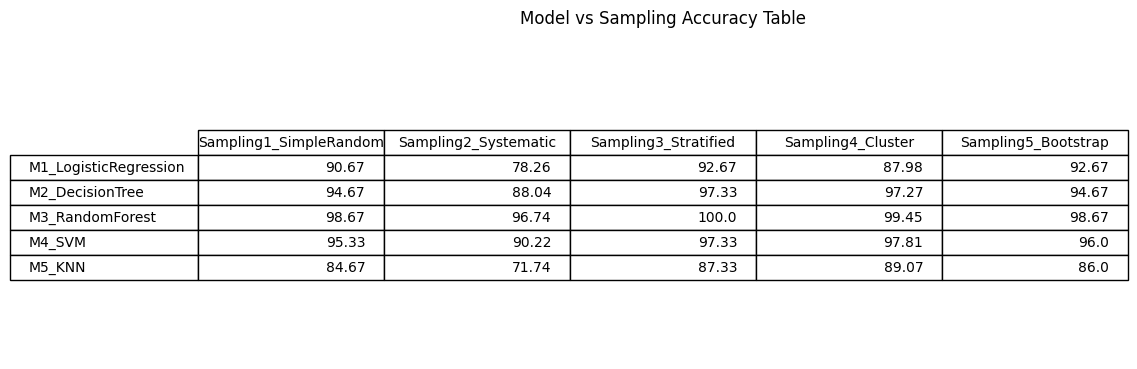


✅ Result table saved as: results.png


In [4]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

from imblearn.over_sampling import SMOTE



df = pd.read_csv('/content/Creditcard_data.csv')

print("\nOriginal Class Distribution:\n", df["Class"].value_counts())


X = df.drop("Class", axis=1)
y = df["Class"]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

df_scaled = pd.DataFrame(X_scaled, columns=X.columns)
df_scaled["Class"] = y.values


smote = SMOTE(random_state=42)
X_bal, y_bal = smote.fit_resample(
    df_scaled.drop("Class", axis=1),
    df_scaled["Class"]
)

balanced_df = pd.DataFrame(X_bal, columns=X.columns)
balanced_df["Class"] = y_bal

print("\nBalanced Class Distribution:\n", balanced_df["Class"].value_counts())




def simple_random_sampling(df, n):
    return df.sample(n=n, random_state=42)


def systematic_sampling(df, k):
    indices = np.arange(0, len(df), k)
    return df.iloc[indices]


def stratified_sampling(df, target_col, n_per_class):
    return df.groupby(target_col, group_keys=False).apply(
        lambda x: x.sample(min(len(x), n_per_class), random_state=42)
    )


def cluster_sampling(df, num_clusters):
    temp = df.copy()
    temp["Cluster"] = pd.qcut(temp["Amount"], q=5, labels=False, duplicates="drop")

    clusters = temp["Cluster"].unique()
    selected_clusters = np.random.choice(clusters, num_clusters, replace=False)

    sampled = temp[temp["Cluster"].isin(selected_clusters)]
    return sampled.drop("Cluster", axis=1)


def bootstrap_sampling(df, n):
    return df.sample(n=n, replace=True, random_state=42)


sample_size = 500

S1 = simple_random_sampling(balanced_df, sample_size)
S2 = systematic_sampling(balanced_df, k=5)
S3 = stratified_sampling(balanced_df, "Class", n_per_class=250)
S4 = cluster_sampling(balanced_df, num_clusters=2)
S5 = bootstrap_sampling(balanced_df, sample_size)

samples = {
    "Sampling1_SimpleRandom": S1,
    "Sampling2_Systematic": S2,
    "Sampling3_Stratified": S3,
    "Sampling4_Cluster": S4,
    "Sampling5_Bootstrap": S5
}


models = {
    "M1_LogisticRegression": LogisticRegression(max_iter=1000),
    "M2_DecisionTree": DecisionTreeClassifier(),
    "M3_RandomForest": RandomForestClassifier(n_estimators=100),
    "M4_SVM": SVC(),
    "M5_KNN": KNeighborsClassifier()
}


results = []

for s_name, sample in samples.items():
    print(f"\n{s_name} Class Distribution:\n", sample["Class"].value_counts())

    X_sample = sample.drop("Class", axis=1)
    y_sample = sample["Class"]

    X_train, X_test, y_train, y_test = train_test_split(
        X_sample, y_sample, test_size=0.3, random_state=42
    )

    for m_name, model in models.items():
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        acc = accuracy_score(y_test, y_pred)
        results.append([m_name, s_name, round(acc * 100, 2)])

results_df = pd.DataFrame(results, columns=["Model", "Sampling", "Accuracy (%)"])
pivot_table = results_df.pivot(index="Model", columns="Sampling", values="Accuracy (%)")

print("\nFinal Accuracy Table:\n")
print(pivot_table)


print("\nBest Sampling Technique Per Model:\n")

for model in pivot_table.index:
    best_sampling = pivot_table.loc[model].idxmax()
    best_score = pivot_table.loc[model].max()
    print(f"{model} → {best_sampling} ({best_score}%)")


import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 4))
ax.axis('tight')
ax.axis('off')

table_data = pivot_table.round(2)

table = ax.table(
    cellText=table_data.values,
    colLabels=table_data.columns,
    rowLabels=table_data.index,
    loc='center'
)

table.scale(1.2, 1.5)
table.auto_set_font_size(False)
table.set_fontsize(10)

plt.title("Model vs Sampling Accuracy Table", pad=20)

plt.savefig("results.png", dpi=300, bbox_inches="tight")
plt.show()

print("\n✅ Result table saved as: results.png")
